# Прогноз продаж в интернет-магазине

Интернет-магазине «Стримчик» продает по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Знакомство с данными

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
df = pd.read_csv('games.csv')
df.columns = [x.lower() for x in df.columns]
df.year_of_release = df.year_of_release.astype('Int32')

Предоставлены данные до 2016 года.

Описание данных  


Name — название игры  
Platform — платформа  
Year_of_Release — год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы проданных копий)  
EU_sales — продажи в Европе (миллионы проданных копий)  
JP_sales — продажи в Японии (миллионы проданных копий)  
Other_sales — продажи в других странах (миллионы проданных копий)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB  

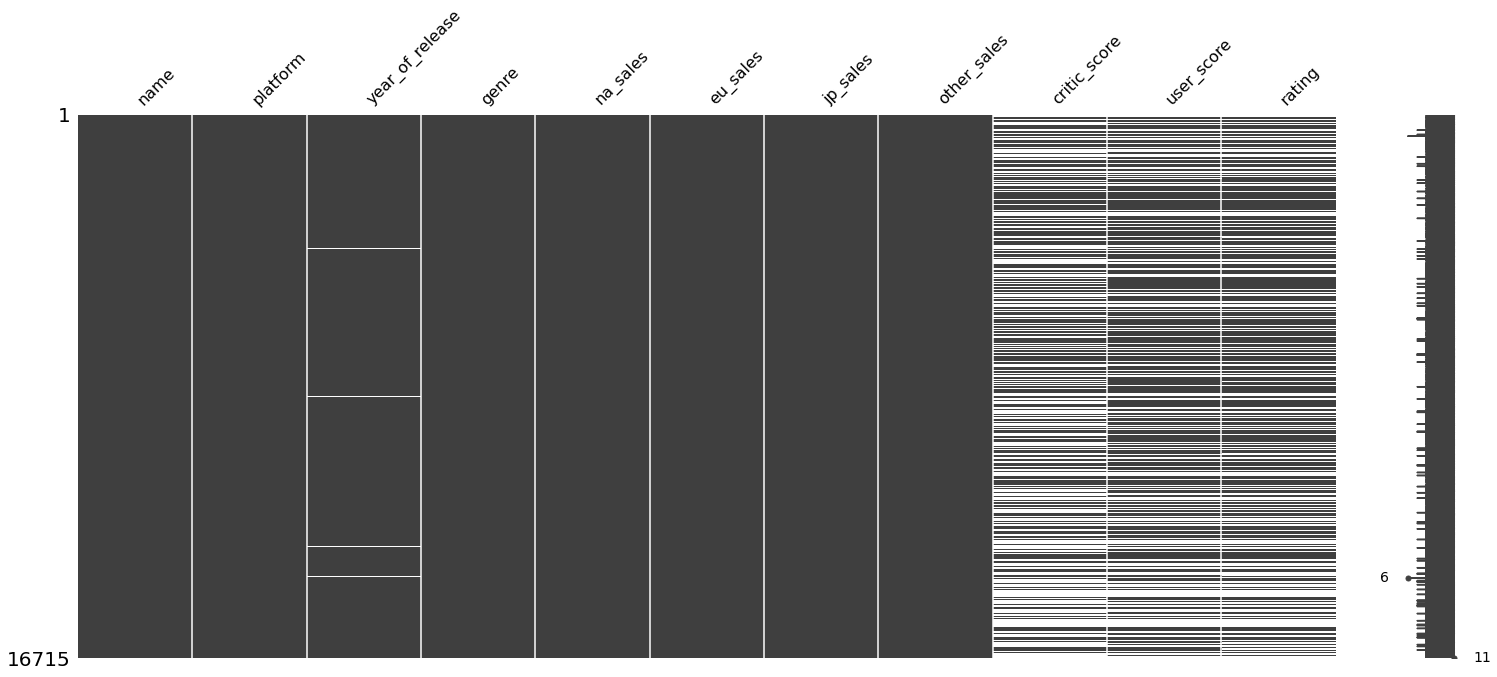

In [3]:
msno.matrix(df)

А теперь остановимся  подробнее на 3 последних колонках.  
Данные с большим количеством пропусков зачастую изначально опасно использовать, чтобы не сделать ложных выводов. В данном случае, к сожалению, мы не имеем динамики продаж игр по месяцам, но скорей всего максимальная покупательная активность проявляется в первые дни после релиза. Задача поставленная в данном анализе, предугадать покупательский ажиотаж к игре после её выхода. Узнать оценку игры до её релиза звучит как минимум не логично. А ожидание пока эта оценка сформируется не позволит получить выгоду в самый активный период спроса.
И даже если попытаться руководствоваться оценкой толпы, а уж тем более "игровых журналистов", в большинстве случаев, она является "голосом" горстки людей которые в игры не играют.
Рейтинг же игры, тем более с таким количеством пропусков, в мире где даже возрастные ограничения на продажу табака и алкоголя не являются значительными трудностями. Не отображает ничего кроме наличие возни, чтобы снова угодить горске людей которые не играют в игры.

На основе всего этого, данные об оценке игры и её рейтинге в дальнейшем анализе использоваться  не будут.

## Предобработка данных

Для обобщенных выводов добавим колонку с общемировыми продажами игры.

In [4]:
df['sales'] = df.na_sales+df.eu_sales+df.jp_sales+df.other_sales

И визуализируем развитие игровой индустрии

Text(0.5, 1.0, 'number of copies sold to the number of games released')

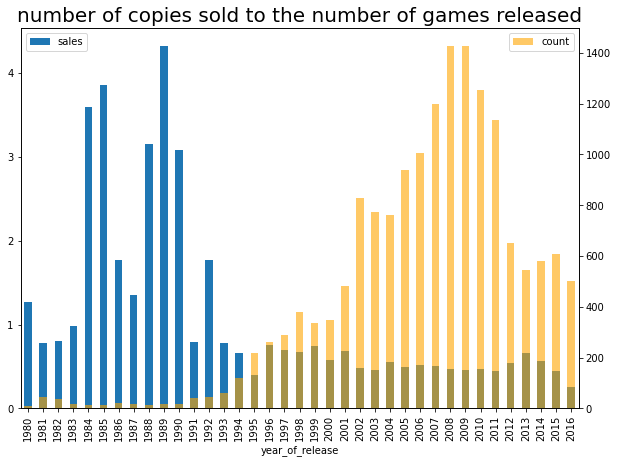

In [6]:
fig, ax1 = plt.subplots()
ax1 = df.groupby('year_of_release').sales.mean().sort_index().plot(kind='bar', figsize=(10,7))
ax2= ax1.twinx()
ax2 = df.groupby('year_of_release').name.count().sort_index().plot(kind='bar', alpha=0.6,color='orange', label='count')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('number of copies sold to the number of games released',fontsize=20)


Данные за 2016 неоправдано малы. Вероятно это связано с тем, что большая часть цикла продаж растягивается на 1-3 года. С этим же может быть связан спад 2014 и 2015 годов. Но так как показатели не сильно отличаются от средних, эти года мы оставим.  
Чтобы спрогнозировать продажи игр 2016 года необходима статистика продаж по месяцам.

В период до 2002 года игровая индустрия только зарождалась. Не было понятий об игровых приставках и игровых жанрах, играли во все что угодня на всем что угодно.   
Анализировать какую еду предпочитает голодный не имеет смысла, поэтому отбросим игры до 2002 года

In [7]:
df = df[df.year_of_release >= 2002]

И взглянем на актуальность приставок

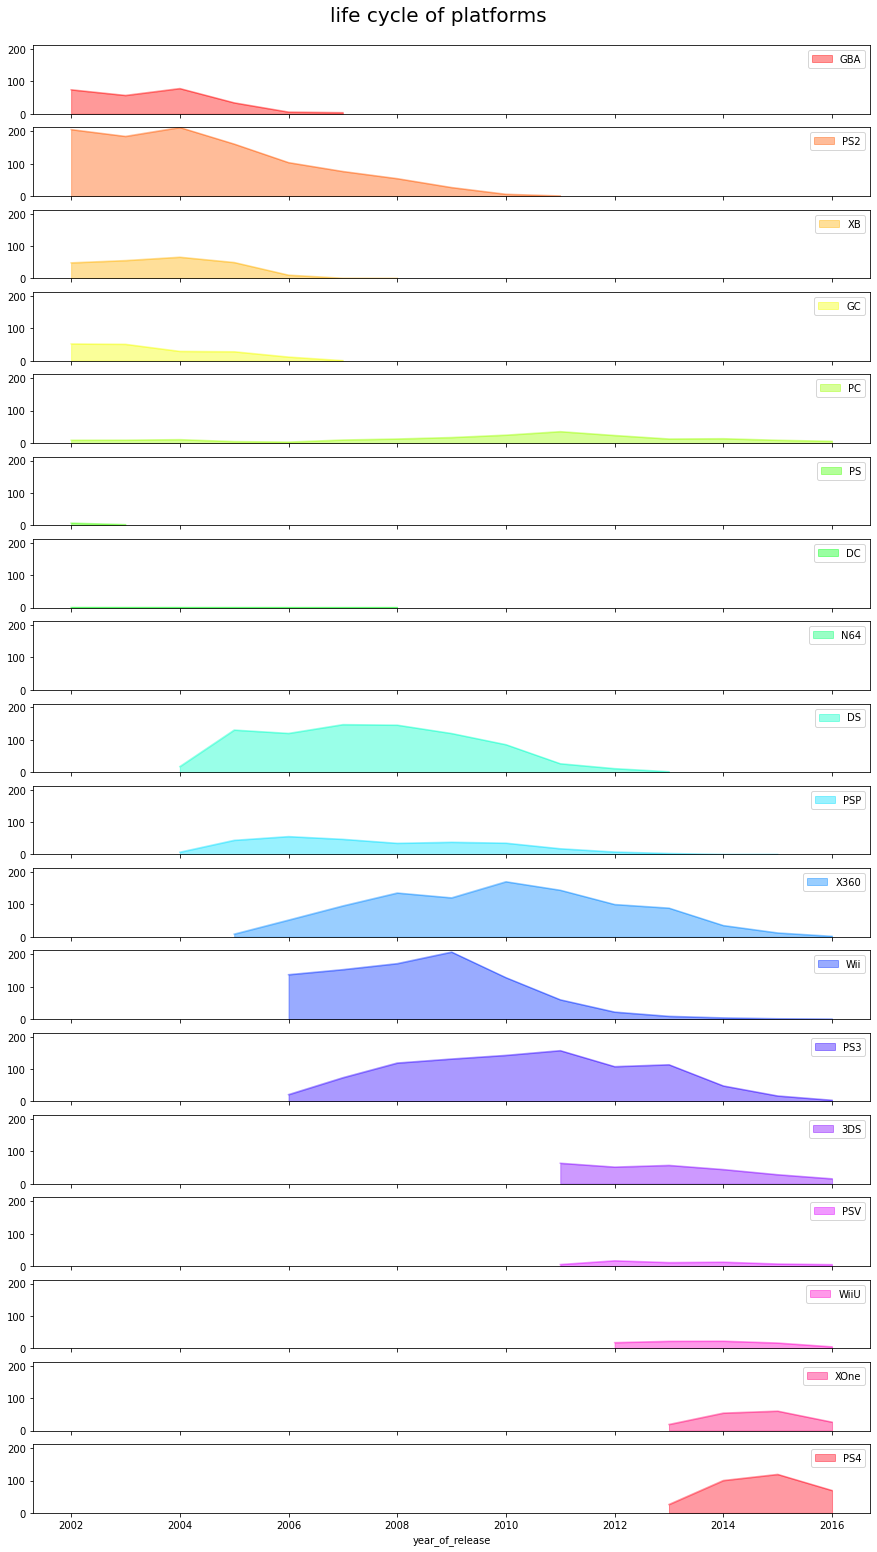

In [34]:
plt_max_sales = df.groupby(['year_of_release', 'platform']).sales.sum().max()


f, axs = plt.subplots(len(df.platform.unique()), 1,
                      figsize=(15,len(df.platform.unique())*1.5),
                      sharex=True, sharey=True)
plt.suptitle('life cycle of platforms', fontsize=20, y=0.9)

axs = axs.ravel()
for i,plform in enumerate(df.sort_values('year_of_release').platform.unique()):
  df[df.platform == plform].\
  groupby(['year_of_release'])\
  .sales.sum().reset_index()\
  .plot.area(ax=axs[i],
             x='year_of_release',
             y='sales',
             label=plform,
             color=plt.cm.get_cmap('hsv', len(df.platform.unique()))(i),
             alpha=0.4,
             ylim=(0,plt_max_sales))

У каждой платформы (за исключением бессмертного ПК) имеется цикл жизни. По истечению которого (чаще всего с выходом консоли нового поколения) платформа становится не актуальной. Исходя из этого оставим топ 5 платформ актуальные на 2016 год и будем рассматривать игры не старше года их выпуска (2013)

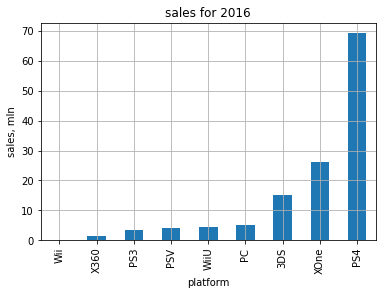

In [38]:
df[df.year_of_release == 2016].groupby('platform')\
                              .sales.sum().sort_values()\
                              .plot(kind='bar',
                                    grid=True).set(ylabel='sales, mln',
                                                   title='sales for 2016');

In [40]:
df = df.query("(year_of_release >= 2013) & (platform in ['PS4', '3DS', 'XOne', 'WiiU', 'PC'])", engine='python')

Не маловажным является "репутация" игровой серии. Существуют армии поклонников вселенных написанными фантастами. Которые готовы покупать новые игры только за их названия. 

In [41]:
df['series_name'] = df.name.apply(lambda x: x.split(':')[0])\
                           .str.replace(r"\b (['\d+IVXK]+\b|\(.+?\))", '')
# создание дополнительной колонки с названием серии игр
#на основе названия игры без римских и арабских цифр
#без уточнений в скобках и после символа ":"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
df[df.sales > df.sales.quantile(0.9)].series_name.unique()

array(['Call of Duty', 'Pokemon/Pokemon Y', 'Grand Theft Auto',
       'Pokemon Omega Ruby/Pokemon Alpha Sapphire', 'FIFA',
       'Star Wars Battlefront', 'Super Smash Bros. for Wii U and 3DS',
       'Fallout', 'Pokemon Sun/Moon', 'Mario Kart', 'Destiny',
       'Uncharted', 'Tomodachi Life', 'The Last of Us', "Luigi's Mansion",
       'Halo', 'Splatoon', 'Super Mario 3D World', 'Minecraft',
       'Battlefield', 'Watch Dogs', 'Far Cry', 'The Witcher',
       "Assassin's Creed", 'Batman', 'Monster Hunter Ultimate', 'NBA',
       "Tom Clancy's The Division", 'Monster Hunter', 'Metal Gear Solid',
       "Assassin's Creed Syndicate", 'Yokai Watch Ganso/Honke',
       'Gears of War', 'Madden NFL', 'Super Mario Maker',
       'The Legend of Zelda', 'Animal Crossing', 'The Sims',
       'Middle-Earth', 'Titanfall', 'inFAMOUS', 'Mortal Kombat',
       'Killzone', 'Yokai Watch Shinuchi', 'Bloodborne', 'Need for Speed',
       'Yokai Watch Busters', 'New Super Luigi U',
       "Tom Clancy's R

Классифицировав доступными методами игры по сериям, в интересующей группе самых популярных игр имеется дублирование серий из-за уникальных форматов названий.  
Их обработаем вручную. 

In [43]:
s_games = ["Pokemon",
           "Mario|Luigi|Smash Bros.",
           "Assassin's Creed",
           "Lego|LEGO",
           "Monster Hunter",
           "Yokai Watch",
           "Need for Speed",
           'Final Fantasy']

for games in s_games:
  df.loc[(df.series_name.str.contains(games)), 'series_name'] = games

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## Анализ данных

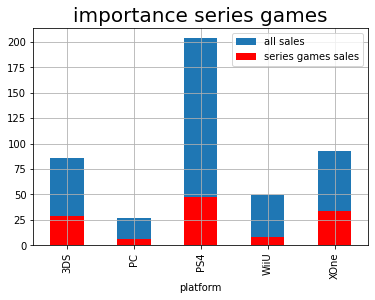

In [45]:
df2 = df.groupby(['series_name',
                 'genre',
                 'platform']).agg({'sales': 'mean',
                                   'name': 'count'}).sort_values('sales',
                                                                 ascending=False)
df2.groupby('platform').sales.sum().plot(kind='bar',
                                        label='all sales')

df2.query("name>1").groupby('platform').sales.sum().plot(kind='bar',
                                                         color='r',
                                                         label='series games sales')
plt.legend()
plt.grid()
plt.title('importance series games', fontsize=20);


Серии игр действительно занимают значительную долю в продажах.

In [44]:
top_sales = {}
# словарь датафреймов с самыми популярными сериями игр в регионе
top_sales_one = {}
# словарь датафреймов с самыми популярными уникальными играми в регионе
regions = ['na', 'eu', 'jp', 'other']
for r in regions:
  top_sales[r] = df.groupby(['series_name', 'genre', 'platform'])\
                  .agg({f'{r}_sales': 'mean', 'name': 'count'})\
                  .sort_values(f'{r}_sales', ascending=False)\
                  .query("name>1")
  top_sales_one[r] = df.groupby(['series_name', 'genre', 'platform'])\
                  .agg({f'{r}_sales': 'mean', 'name': 'count'})\
                  .sort_values(f'{r}_sales', ascending=False)\
                  .query("name==1")

Рассмотрим самые популярные игровые франшизы

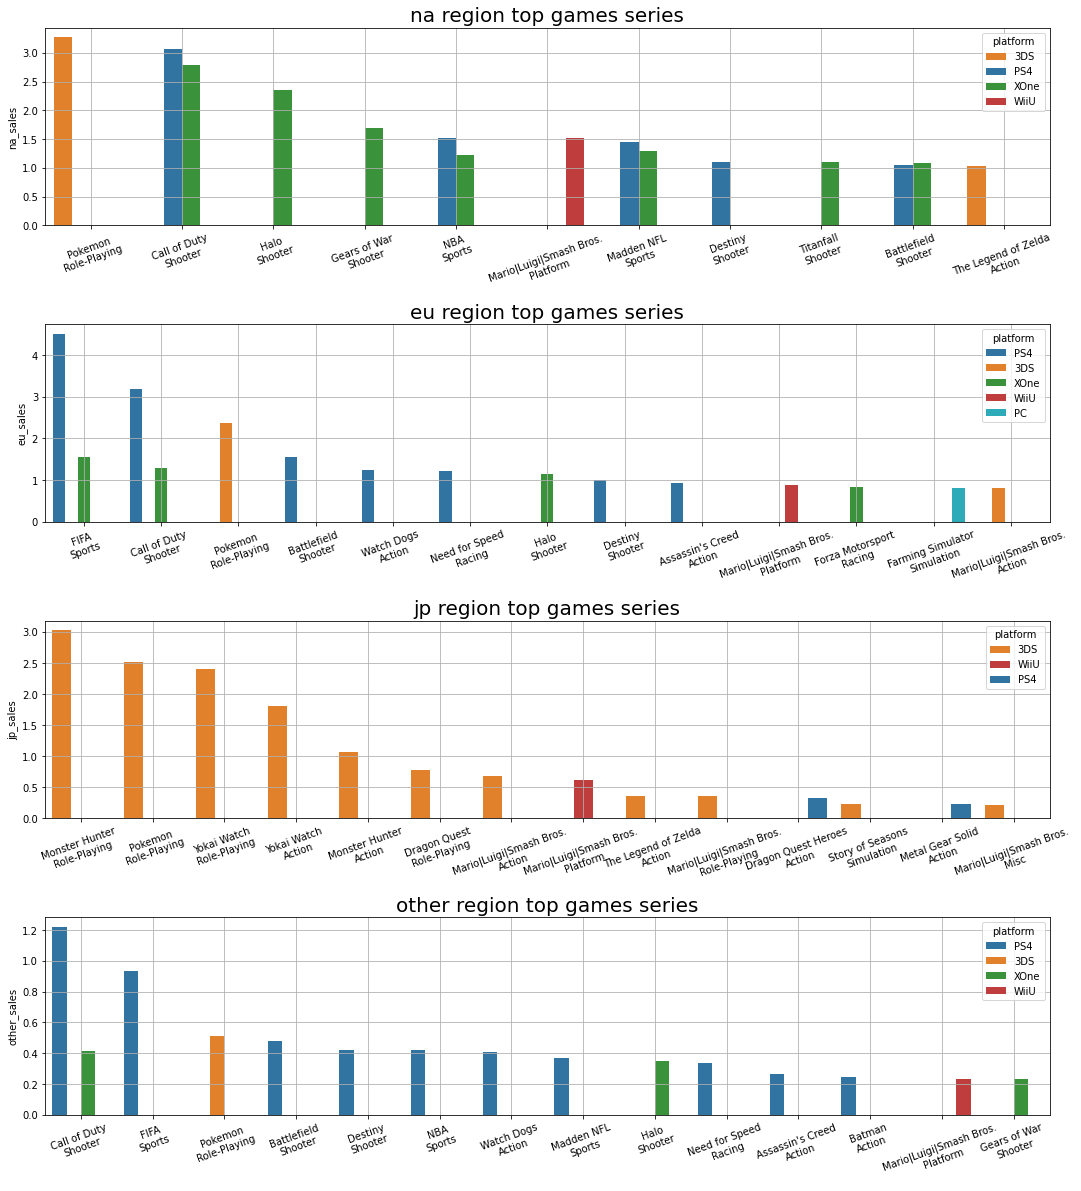

In [47]:
f, axs = plt.subplots(len(regions), 1, figsize=(18,20))
axs = axs.ravel()
plt.subplots_adjust(hspace=0.5)
palette = {'PS4': 'tab:blue',
           'XOne': 'tab:green',
           '3DS': 'tab:orange',
           'WiiU': 'tab:red',
           'PC': 'tab:cyan',}

for i,reg in enumerate(regions):
  #plt.xticks(rotation=15)
  data = top_sales[reg].reset_index().query(f"{reg}_sales>{reg}_sales.quantile(0.9)")
  sns.barplot(ax=axs[i],
              data=data,
              x=data.series_name+'\n'+data.genre,
              y=f'{reg}_sales',
              hue='platform',
              palette=palette).set_title(f'{reg} region top games series',
                                         fontsize = 20)
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=20)
  axs[i].xaxis.grid(True)
  axs[i].yaxis.grid(True)

А теперь рассмотрим самые популярные уникальные игры за рассматриваемый период

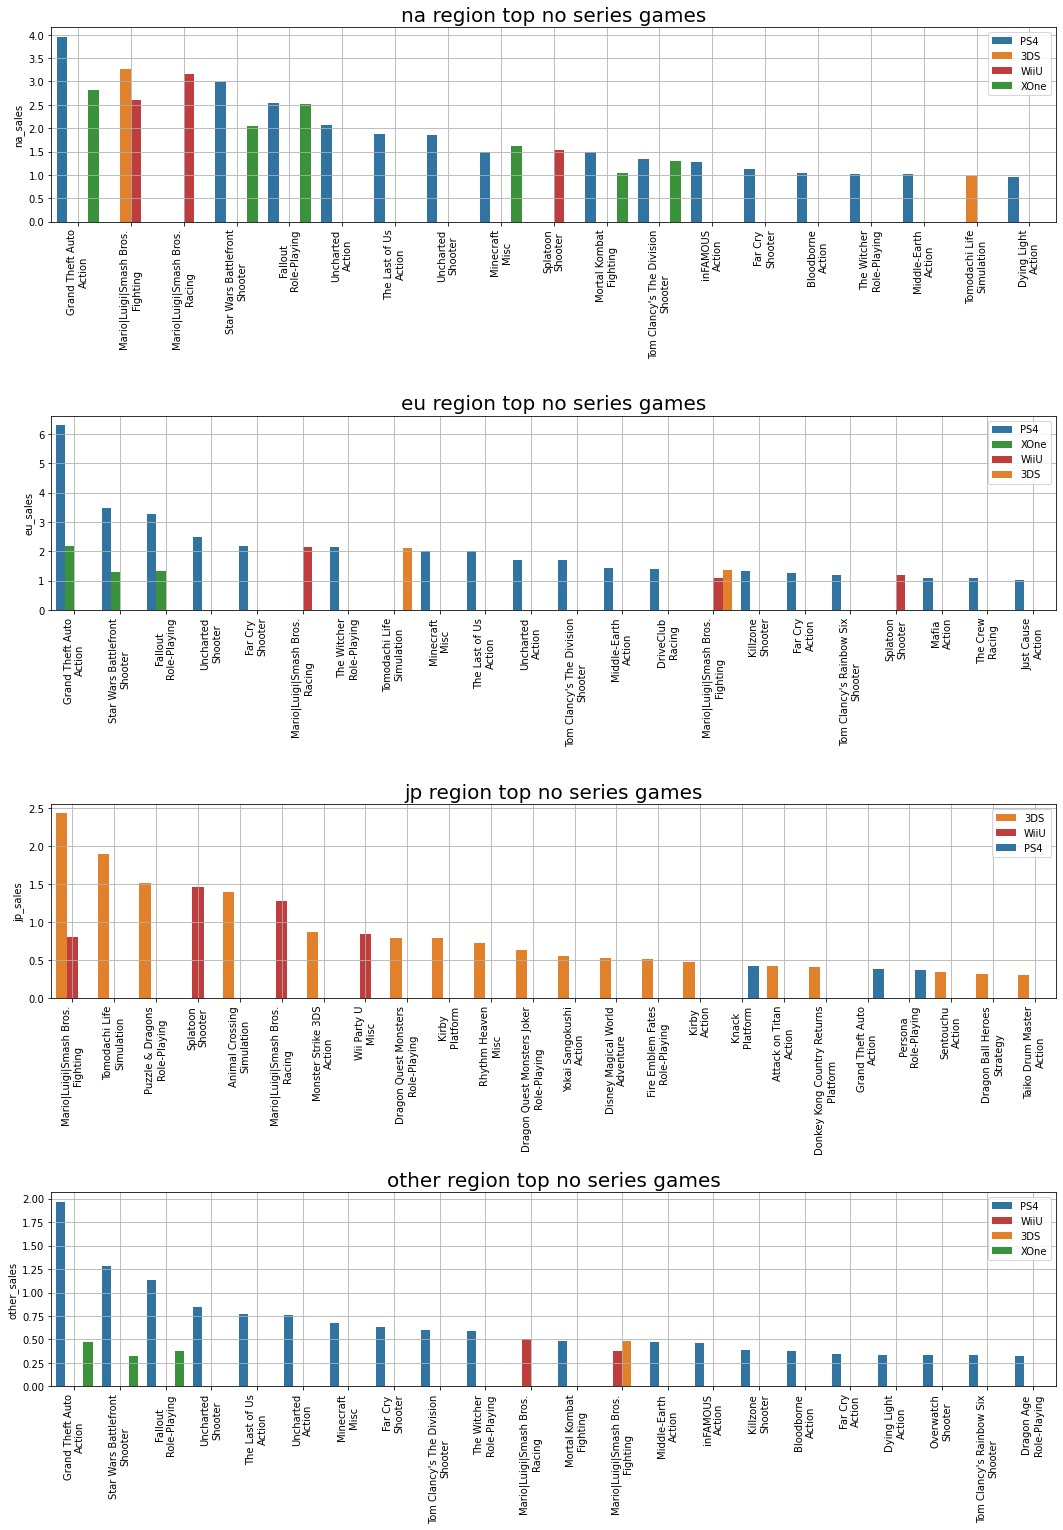

In [50]:
f, axs = plt.subplots(len(regions), 1, figsize=(18,25))
axs = axs.ravel()
plt.subplots_adjust(hspace=1)
palette = {'PS4': 'tab:blue',
           'XOne': 'tab:green',
           '3DS': 'tab:orange',
           'WiiU': 'tab:red',
           'PC': 'tab:cyan',}

for i,reg in enumerate(regions):
  #plt.xticks(rotation=15)
  data = top_sales_one[reg].reset_index().query(f"{reg}_sales>{reg}_sales.quantile(0.97)")
  sns.barplot(ax=axs[i],
              data=data,
              x=data.series_name+'\n'+data.genre,
              y=f'{reg}_sales',
              hue='platform',
              palette=palette).set_title(f'{reg} region top no series games',
                                         fontsize = 20)
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
  axs[i].legend(loc='upper right')
  axs[i].xaxis.grid(True)
  axs[i].yaxis.grid(True)

Так как вынужденный метод для группировки данных по франшизам оказался не идеальным, большое количество игр с циклом разработки продолжений более 4 лет оказались в данном топе. Но это дополнительно показывает значимость игровой репутации в современном игрострое.

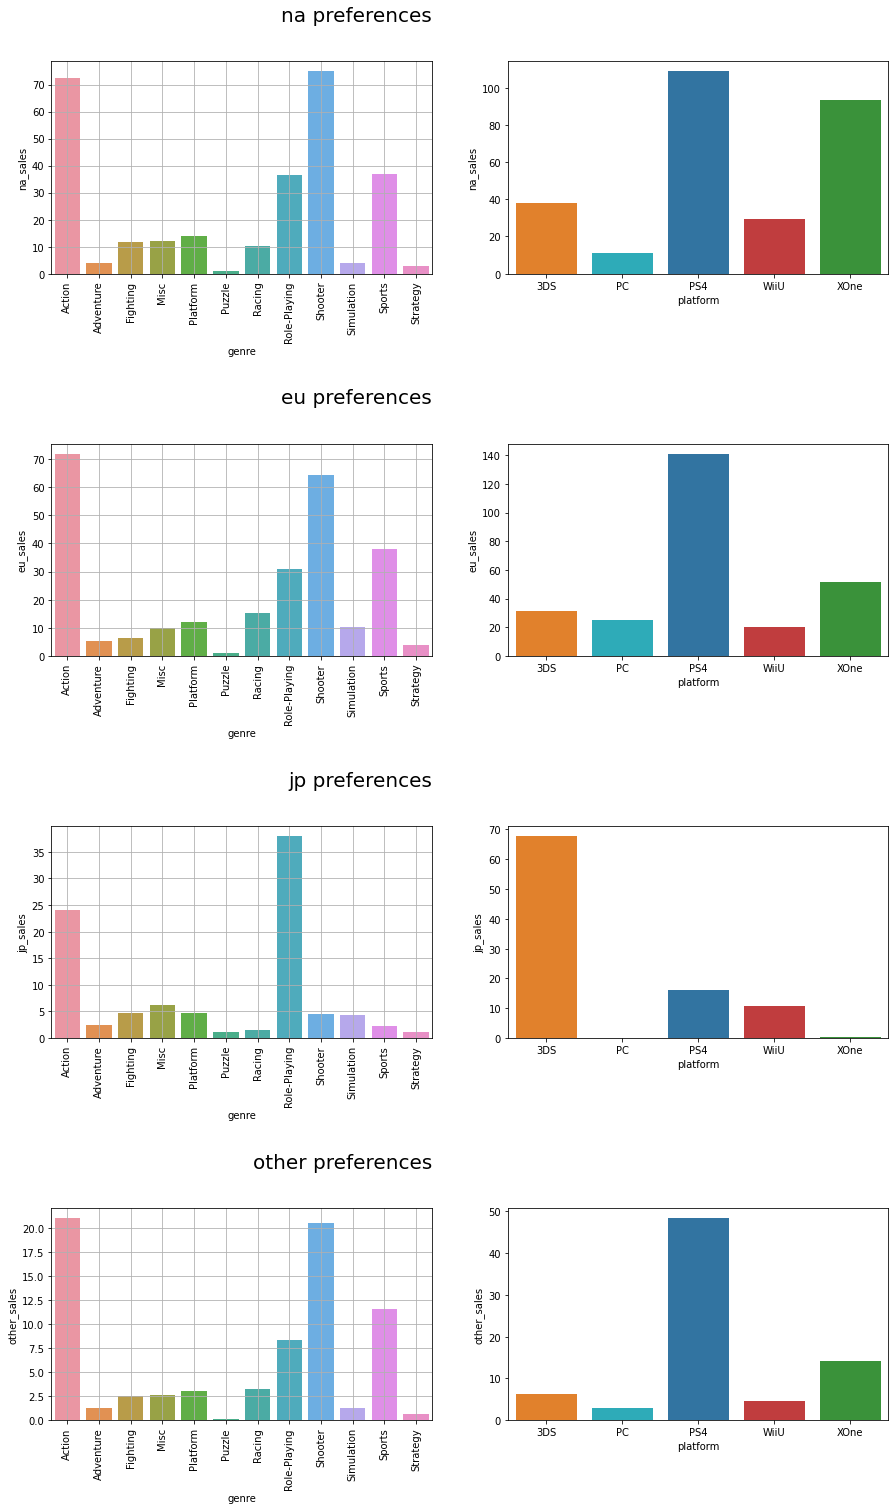

In [51]:
f, axs = plt.subplots(len(regions), 2, figsize=(15,25))
axs = axs.ravel()
plt.subplots_adjust(hspace=0.8)
palette = {'PS4': 'tab:blue',
           'XOne': 'tab:green',
           '3DS': 'tab:orange',
           'WiiU': 'tab:red',
           'PC': 'tab:cyan',}
i=-1
for reg in regions:
  i+=1
  sns.barplot(ax=axs[i], data=df.groupby(['genre'])[f'{reg}_sales'].sum().reset_index(),
              x='genre',
              y=f'{reg}_sales').set_title(f'{reg} preferences',
                                          fontsize = 20,
                                          loc='right',
                                          pad = 40)
  
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
  axs[i].xaxis.grid(True)
  axs[i].yaxis.grid(True)

  i+=1
  sns.barplot(ax=axs[i], data=df.groupby(['platform'])[f'{reg}_sales'].sum().reset_index(),
              x='platform',
              y=f'{reg}_sales',
              palette=palette)

Стоит считаться с тем, что игровые предпочтения Японии кардинально отличаются от остального мира.

Для окончательных выводов остальность взлянуть на мастаб рынков разбитых по регионам

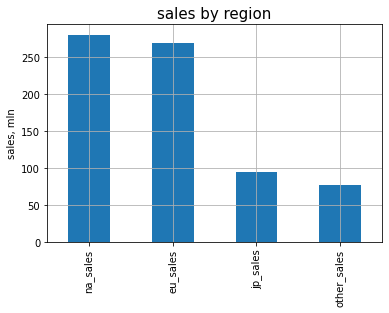

In [ ]:
plt.title('sales by region', fontsize=15)
plt.ylabel('sales, mln')
df.loc[:,['na_sales',
          'eu_sales',
          'jp_sales',
          'other_sales']].sum().plot(kind='bar', grid=True);

## Выводы

1. В первую очередь стоит обратить внимание на потребление игрового контента по регионам.  
 75% всех проданных игр были приобретены в Североамериканском и Европейском регионах.  

2. Большая часть игр приобретается для консолей нового поколения.  
  2.1. Для Североамериканского региона 60% игр покупаются на консоли PS4 и XOne  
  2.2. Для Японии 70% купленных игр прихотся на приставку 3DS и только 20% у PS4  
  2.3.  Во всем остальном мире 60% игровой индустрии принадлежит PS4    

3. Игры которые вероятней всего будут популярными в будущем и на которые с минимальным риском можно сделать ставку, относятся к уже зарекомендовавшим себя сериям игр. Список самых популярных из них отображен в работе на графиках. И к ним относятся игры таких серий как FIFA, Call of Duty, Pokemon, Mario, GTA, Star Wars и др.

4. Самыми популярными жанрами для Японии являются Action и RP. Для всего остального мира Action, RP, Shooter и Sport
